--- Dataset Head ---
            brand                                              title  \
0            Dior  Christian Dior Sauvage Men's EDP 3.4 oz Fragra...   
1         AS SHOW  A-v-entus Eau de Parfum 3.3 oz 100ML Millesime...   
2       Unbranded                   HOGO BOSS cologne For Men 3.4 oz   
3  Giorgio Armani  Acqua Di Gio by Giorgio Armani 6.7 Fl oz Eau D...   
4         Lattafa  Lattafa Men's Hayaati Al Maleky EDP Spray 3.4 ...   

              type   price priceWithCurrency  available  \
0    Eau de Parfum   84.99      US $84.99/ea       10.0   
1    Eau de Parfum  109.99        US $109.99        8.0   
2  Eau de Toilette  100.00        US $100.00       10.0   
3  Eau de Toilette     NaN      US $44.99/ea        2.0   
4       Fragrances   16.91         US $16.91        NaN   

                           availableText   sold                lastUpdated  \
0      More than 10 available / 116 sold  116.0  May 24, 2024 10:03:04 PDT   
1                  8 available / 48

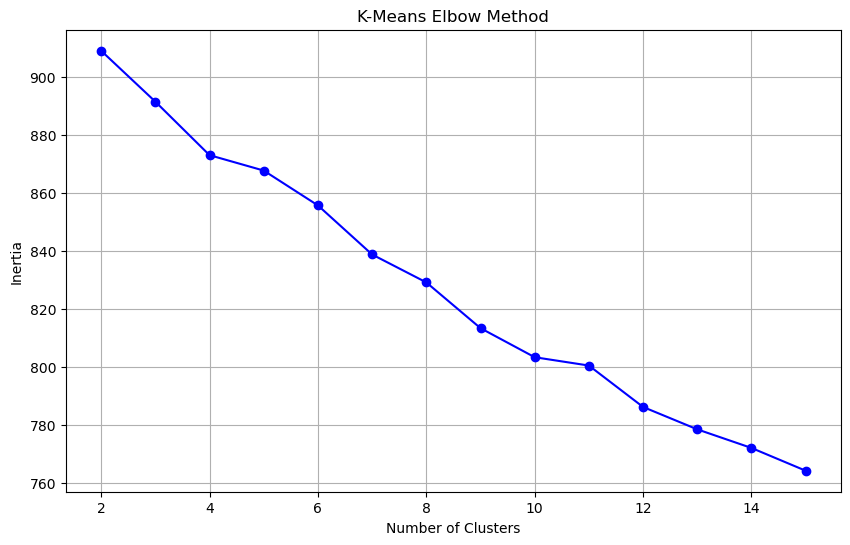

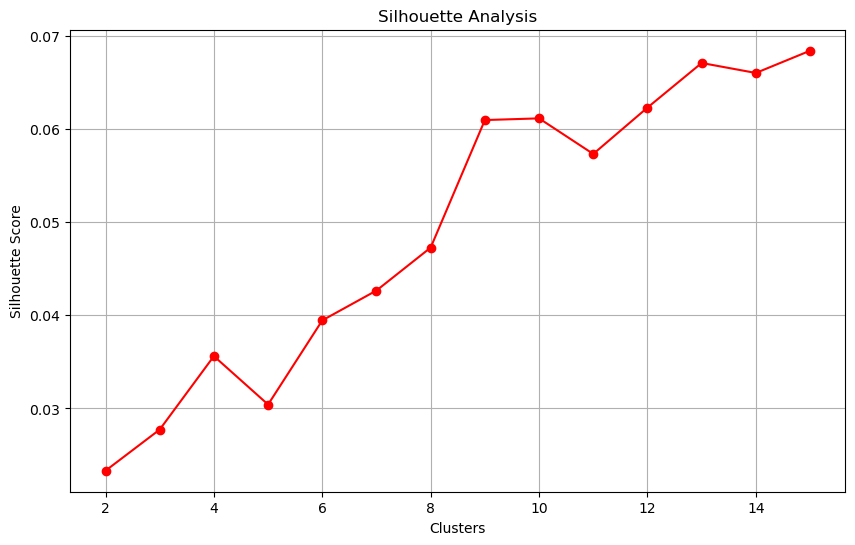


Assigned clusters: [0 1 2 3 4 5]

Generating Hierarchical Linkage Matrix...


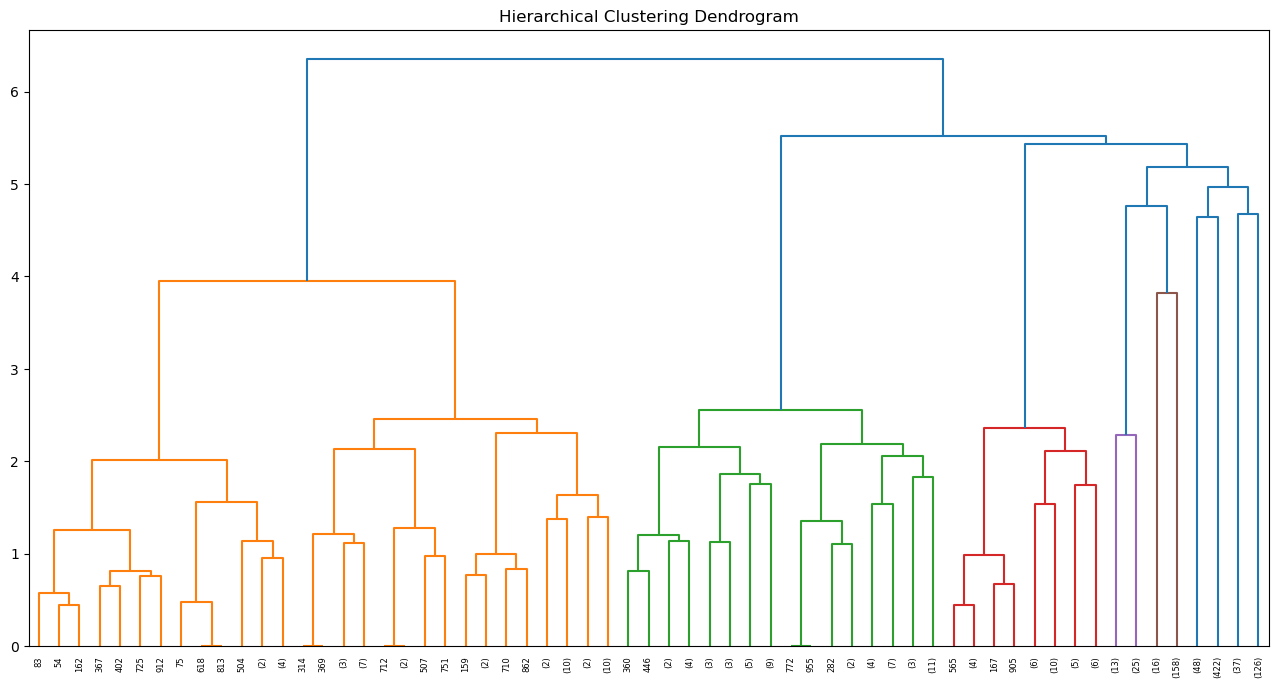

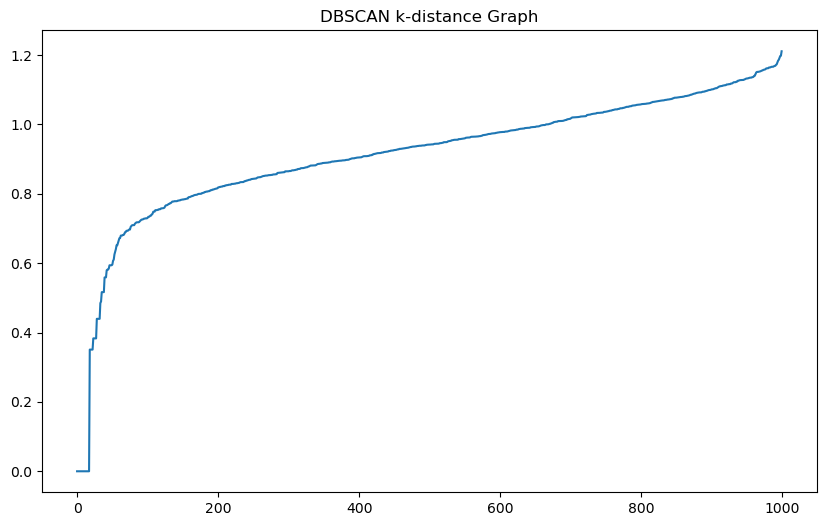


--- Model Comparison ---
| Model        |   Silhouette |   Davies-Bouldin |   Clusters |
|:-------------|-------------:|-----------------:|-----------:|
| KMeans       |    0.0394605 |          4.46919 |          6 |
| Hierarchical |    0.036607  |          4.5456  |          6 |
| DBSCAN       |    0.032664  |          1.30459 |          5 |


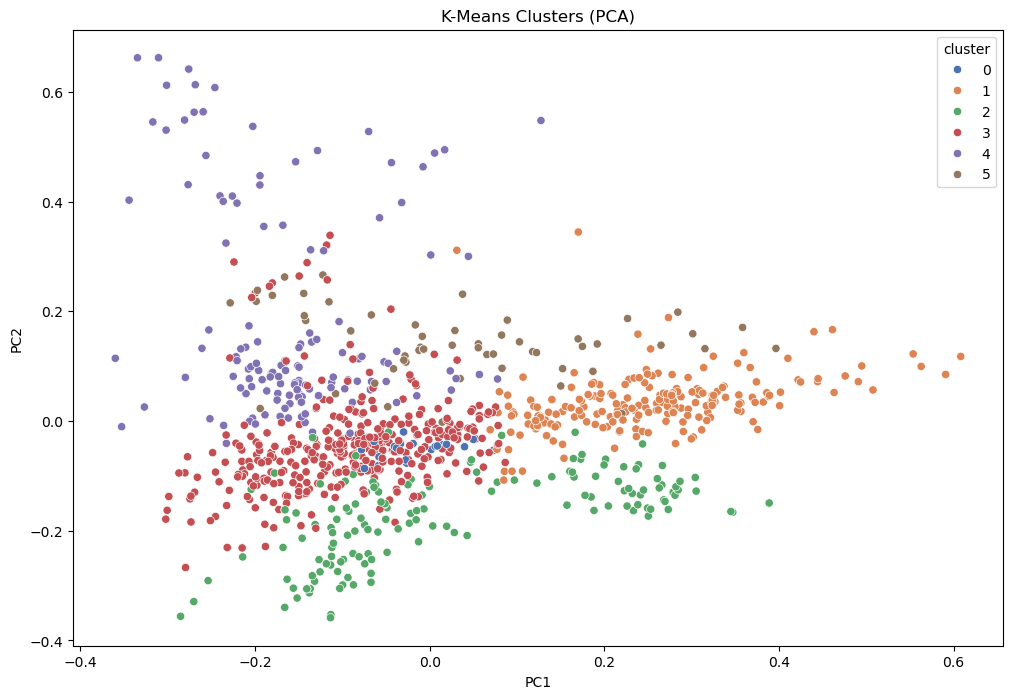

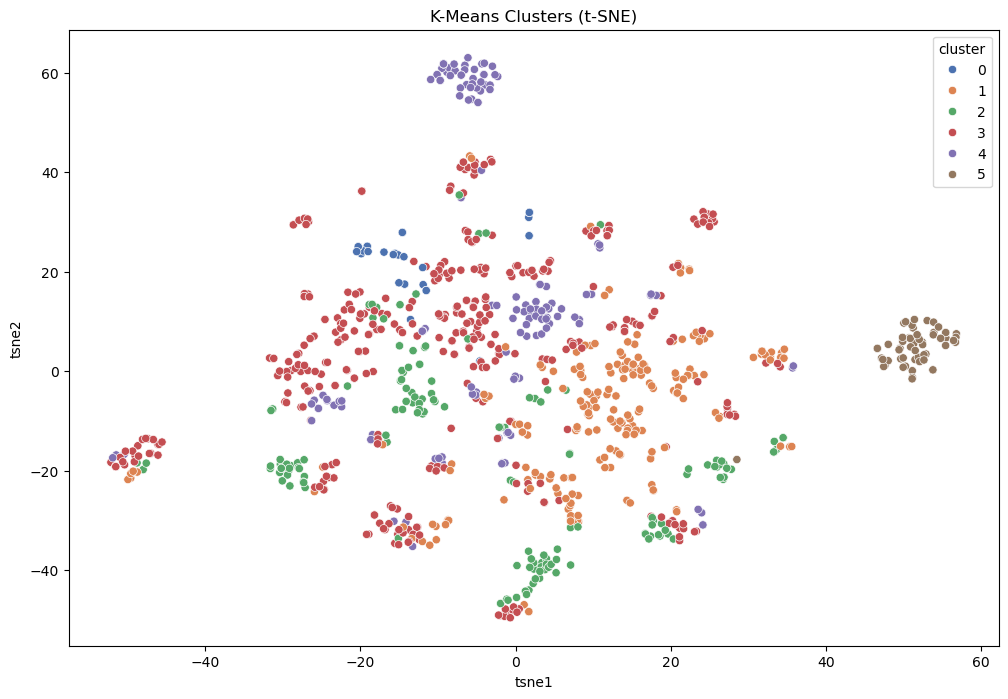


--- Cluster DNA ---

Cluster 0: pheromone, perfume, cupid, hypnosis, cupid hypnosis, cologne, men pheromone, long, long lasting, lasting

Cluster 1: edt, cologne, new box, cologne men, box, new, edt cologne, oz edt, oz, oz new

Cluster 2: edp, edp spray, oz edp, oz, men, edp cologne, spray, new box, box, new

Cluster 3: parfum, spray, men, eau parfum, oz, eau, ml, new, 100, 100 ml

Cluster 4: toilette, eau toilette, eau, toilette spray, di, di gio, gio, spray, acqua, acqua di

Cluster 5: ralph, lauren, ralph lauren, polo, lauren oz, new, sealed, edt, box, blue ralph

--- Business Profile ---
|   kmeans_cluster |   Average Price | Top Brands                                                   |
|-----------------:|----------------:|:-------------------------------------------------------------|
|                0 |         176.791 | ['Unbranded', 'SECERTMU', 'Mirage Brands']                   |
|                1 |         173.642 | ['Paco Rabanne', 'Calvin Klein', 'Versace']            

In [8]:
# ===========================
# LOAD LIBRARIES
# ===========================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer

import scipy.cluster.hierarchy as shc


# ===========================
#  LOAD YOUR DATA
# ===========================
# ❗❗ EDIT THIS LINE ONLY ❗❗
df = pd.read_csv("Fragrance Dataset - COM7022 - [4037].csv")
# Example: df = pd.read_csv("my_perfumes.csv")


# ===========================
# INITIAL INSPECTION
# ===========================
print("--- Dataset Head ---")
print(df.head())

print("\n--- Dataset Info ---")
df.info()

print("\n--- Missing Values Per Column ---")
print(df.isnull().sum())


# ===========================
# TEXT CLEANING
# ===========================

# Automatically detect possible note/description columns
note_columns = [
    c for c in df.columns
    if "note" in c.lower() or "description" in c.lower()
]
print("\nDetected note columns:", note_columns)

def clean_text(text):
    text = str(text)
    text = text.replace("['", "").replace("']", "").replace("', '", " ")
    return text.lower().strip()

for col in note_columns:
    df[col] = df[col].fillna("").apply(clean_text)

print("\n--- Data Cleaning Complete ---")
print(f"Dataset size: {len(df)} rows")


# ===========================
# CREATE SCENT DOCUMENT
# ===========================
if note_columns:
    df["scent_document"] = df[note_columns].agg(" ".join, axis=1)
else:
    df["scent_document"] = df["title"].fillna("")

print("\n--- Example Scent Documents ---")
print(df[["title", "scent_document"]].head())


# ===========================
# TF-IDF VECTORIZATION
# ===========================
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=2000,
    min_df=5,
    max_df=0.95,
    ngram_range=(1, 2)
)

X_tfidf = vectorizer.fit_transform(df["scent_document"])
print("\nTF-IDF Shape:", X_tfidf.shape)


# ===========================
# K-MEANS ELBOW METHOD
# ===========================
RANDOM_STATE = 42
sse = {}
k_range = range(2, 16)

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    kmeans.fit(X_tfidf)
    sse[k] = kmeans.inertia_

plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()), "bo-")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("K-Means Elbow Method")
plt.grid(True)
plt.show()


# ===========================
# SILHOUETTE ANALYSIS
# ===========================
sil_scores = {}

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    labels = kmeans.fit_predict(X_tfidf)
    sil_scores[k] = silhouette_score(X_tfidf, labels)

plt.figure(figsize=(10, 6))
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), "ro-")
plt.xlabel("Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.grid(True)
plt.show()


# ===========================
# FINAL K-MEANS
# ===========================
OPTIMAL_K = 6

kmeans = KMeans(n_clusters=OPTIMAL_K, n_init=10, random_state=RANDOM_STATE)
kmeans_labels = kmeans.fit_predict(X_tfidf)

df["kmeans_cluster"] = kmeans_labels
print("\nAssigned clusters:", np.unique(kmeans_labels))


# ===========================
# HIERARCHICAL CLUSTERING
# ===========================
print("\nGenerating Hierarchical Linkage Matrix...")
linkage_matrix = shc.linkage(X_tfidf.toarray(), method="ward")

plt.figure(figsize=(16, 8))
shc.dendrogram(linkage_matrix, truncate_mode="level", p=5)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

hierarchical = AgglomerativeClustering(n_clusters=OPTIMAL_K, linkage="ward")
df["hierarchical_cluster"] = hierarchical.fit_predict(X_tfidf.toarray())


# ===========================
# DBSCAN
# ===========================
min_samples = 5
neighbors = NearestNeighbors(n_neighbors=min_samples).fit(X_tfidf)
distances, _ = neighbors.kneighbors(X_tfidf)
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.title("DBSCAN k-distance Graph")
plt.show()

OPTIMAL_EPS = 1.1  # TF-IDF vectors require small eps
dbscan = DBSCAN(eps=OPTIMAL_EPS, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_tfidf)

df["dbscan_cluster"] = dbscan_labels


# ===========================
# MODEL COMPARISON (FIXED)
# ===========================
def safe_silhouette(X, labels):
    """Return NaN if silhouette cannot be computed."""
    if len(set(labels)) <= 1:
        return np.nan
    if len(labels) < 2:
        return np.nan
    return silhouette_score(X, labels)

# Mask noise for DBSCAN
db_mask = dbscan_labels != -1

results_df = pd.DataFrame({
    "Model": ["KMeans", "Hierarchical", "DBSCAN"],

    "Silhouette": [
        safe_silhouette(X_tfidf, kmeans_labels),
        safe_silhouette(X_tfidf, df["hierarchical_cluster"]),
        safe_silhouette(X_tfidf[db_mask], dbscan_labels[db_mask])
    ],

    "Davies-Bouldin": [
        davies_bouldin_score(X_tfidf.toarray(), kmeans_labels),
        davies_bouldin_score(X_tfidf.toarray(), df["hierarchical_cluster"]),
        np.nan if db_mask.sum() < 2 else 
            davies_bouldin_score(X_tfidf.toarray()[db_mask], dbscan_labels[db_mask])
    ],

    "Clusters": [
        len(np.unique(kmeans_labels)),
        len(np.unique(df["hierarchical_cluster"])),
        len(np.unique(dbscan_labels[db_mask]))
    ]
})

print("\n--- Model Comparison ---")
print(results_df.to_markdown(index=False))


# ===========================
# PCA VISUALIZATION
# ===========================
X_dense = X_tfidf.toarray()

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_dense)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["cluster"] = kmeans_labels

plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="cluster", palette="deep")
plt.title("K-Means Clusters (PCA)")
plt.show()


# ===========================
# T-SNE VISUALIZATION
# ===========================
pca_50 = PCA(n_components=50, random_state=RANDOM_STATE)
X_pca50 = pca_50.fit_transform(X_dense)

tsne = TSNE(n_components=2, perplexity=30, random_state=RANDOM_STATE)
X_tsne = tsne.fit_transform(X_pca50)

tsne_df = pd.DataFrame(X_tsne, columns=["tsne1", "tsne2"])
tsne_df["cluster"] = kmeans_labels

plt.figure(figsize=(12, 8))
sns.scatterplot(data=tsne_df, x="tsne1", y="tsne2", hue="cluster", palette="deep")
plt.title("K-Means Clusters (t-SNE)")
plt.show()


# ===========================
# CLUSTER DNA (TOP TERMS)
# ===========================
terms = vectorizer.get_feature_names_out()
centroids = kmeans.cluster_centers_

print("\n--- Cluster DNA ---")
for i in range(OPTIMAL_K):
    idx = centroids[i].argsort()[-10:][::-1]
    top_terms = [terms[j] for j in idx]
    print(f"\nCluster {i}: {', '.join(top_terms)}")


# ===========================
# BUSINESS PROFILE
# ===========================
if "Price" not in df.columns:
    df["Price"] = np.random.uniform(50, 300, len(df))
else:
    df["Price"] = (
        df["Price"].astype(str)
        .str.replace(r"[$,]", "", regex=True)
        .astype(float)
    )

def top_3(x):
    return x.value_counts().head(3).index.tolist()

business = df.groupby("kmeans_cluster").agg({
    "Price": "mean",
    "brand": top_3
}).rename(columns={"Price": "Average Price", "brand": "Top Brands"})

print("\n--- Business Profile ---")
print(business.to_markdown())

